<div style="background:#33ceff">
<img src="logo.jpg", width=150, ALIGN="left", border=20>
    <h1>Team ECOLO</h1>
    <h3>Mathis DUPONT, Clémence SEBE</h3>
    <h2>Plankton classification challenge</h2>
    <br/>
    <br/>
    <h4>Historique : </h4>
 <br>10/04/2020 : ajout model.py + preprocess.py ET graphique TSNE<br/>
  <br>11/04/2020 : ajout d'un test qui verifie si le score ne dépasse pas 1<br/>
   <br>13/04/2020 : mise en place d'une boucle pour tester plusieurs modeles<br/>
    <br>17/04/2020 : maj avec preprocessing (version 16/04)<br/>
     <br>18/04/2020 : relecture et maj<br/>
</div>

<div style="background:#f7a310">
<br>08/05/2020 : variations des paramètres de RandomForest <br/>
 </div>

<div style="background:#FFFFAA">
<br>This code was tested with <br>
Python 3.7 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>

<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
     <br>
       
According to [NRMA15], a link has been found between the quality of water and the presence of plankton in said water. As water quality increases, the abundance and diversity of plankton does as well. The aim of our project is to build a plankton classifier to assess water quality.

We use for this problem the Bering Sea dataset, an in situ plankton dataset published in May 2019 by Kaichang Cheng [Che19]. This datset contains 7 classes with an even spread.

        
References and credits: 
- [NRMA15] A. Nair, J.K. Reshma, A. Mathew, and A. Ashok. Effect of water quality on phytoplankton abundance in selected ponds of nedumangad block panchayat, kerala. Emer Life Sci Res, 2015.
- [Che19] K. Cheng. Bering sea dataset. https://doi.org/10.6084/m9.figshare.8146283.v3, 2019.
 <br>
</div>

<img src="images/sample.png" alt="Drawing"/>
To see more images for each class, see the "images" folder.

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

In [2]:
data_dir = 'public_data'              # Change this to the directory where you put the input data
#data_dir = '../public_data'          # The sample_data directory should contain only a very small subset of the data
data_name = 'plankton'
!ls $data_dir*

public_data.zip

public_data:
plankton_feat.name    plankton_test.data       plankton_valid.data
plankton_label.name   plankton_train.data
plankton_public.info  plankton_train.solution


<h3>Two "feature representation"</h3>

<p>
1.
All of the images are in various shades of gray. As such, we can represent every image by a vector of 90000 (300x300) features where each feature is a float value between 0 and 255 representing the brightness of a pixel (0 being a black pixel and 255 a white one). It is also possible to reduce the size of the images to reduce the number of features as seen in figure 3 where we reduced the size to 100x100 pixels.
</p>

<tr>
    <td> <img src="images/gray.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="images/binarized.png" alt="Drawing" style="width: 250px;"/> </td>
</tr>


<p>
2. At first we will have four types of "features". Two "features" are applied on the binarized images.
    <ul>
        <li>The first is a sum of black pixels, per line and per column.
This gives us 2 vectors of size 100. These "features" are representative among others of the shape of the plankton.
For round seeders the ratio between rows and columns near the center of the image should be close.
For longer plankton the ratio will be either low or high, depending on plankton position.
        </li>
        <li>The second is the average of the pixels.
            This gives us information on the size of the plankton.
        </li>
        <li>The third feature is the variance and is applied to non-binarized images.</li>
        <li>The last feature is the length of the contour of the plankton. It is obtained by applying a sobel filter on the image. This filter will put black pixels on the contours and white ones everywhere else. We can then just compute the amount of black pixels.
    </ul>
</p>

For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [3]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading public_data/plankton_train from AutoML format
Number of examples = 10752
Number of features = 203
          Class
0  chaetognatha
1      copepoda
2   euphausiids
3   fish_larvae
4      limacina
5       medusae
6         other
Number of classes = 7


This shows the distribution of labels in the training set

In [4]:
data['target'].value_counts() 

medusae         1536
limacina        1536
other           1536
euphausiids     1536
chaetognatha    1536
copepoda        1536
fish_larvae     1536
Name: target, dtype: int64

The first rows of the dataset.

In [5]:
data.head()

,sum_axis_0_0,sum_axis_0_1,sum_axis_0_2,sum_axis_0_3,sum_axis_0_4,sum_axis_0_5,sum_axis_0_6,sum_axis_0_7,sum_axis_0_8,sum_axis_0_9,...,sum_axis_1_94,sum_axis_1_95,sum_axis_1_96,sum_axis_1_97,sum_axis_1_98,sum_axis_1_99,mean,variance,outline_length,target
0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.83871,0.83871,0.827957,0.817204,0.795699,0.774194,0.744560,0.062088,9.82,other
1,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,0.852347,0.021939,0.64,other
2,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.82000,0.90000,1.000000,1.000000,1.000000,1.000000,0.478031,0.130620,6.68,limacina
3,1.0,1.0,0.99,0.96,0.94,0.94,0.92,0.92,0.92,0.93,...,0.96000,0.99000,1.000000,1.000000,1.000000,1.000000,0.799294,0.037921,6.86,chaetognatha
4,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,0.99000,0.990000,0.990000,1.000000,1.000000,0.713423,0.065195,11.56,medusae


Some statistics about the features.

In [6]:
data.describe() 

,sum_axis_0_0,sum_axis_0_1,sum_axis_0_2,sum_axis_0_3,sum_axis_0_4,sum_axis_0_5,sum_axis_0_6,sum_axis_0_7,sum_axis_0_8,sum_axis_0_9,...,sum_axis_1_93,sum_axis_1_94,sum_axis_1_95,sum_axis_1_96,sum_axis_1_97,sum_axis_1_98,sum_axis_1_99,mean,variance,outline_length
count,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,...,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000
mean,0.979279,0.977036,0.972997,0.965795,0.956058,0.946609,0.938161,0.930047,0.922546,0.914766,...,0.936903,0.943581,0.951833,0.961342,0.966297,0.970557,0.971949,0.677502,0.074303,8.117898
std,0.096922,0.098681,0.099546,0.102380,0.106950,0.113165,0.119380,0.126461,0.132001,0.138568,...,0.118902,0.114981,0.110555,0.106497,0.105424,0.104636,0.105878,0.133997,0.033898,4.244094
min,0.100000,0.050000,0.070000,0.030000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.040000,0.209394,0.001928,0.000000
25%,1.000000,1.000000,1.000000,0.990000,0.960000,0.940000,0.930000,0.916667,0.900000,0.880000,...,0.920000,0.940000,0.950000,0.980000,1.000000,1.000000,1.000000,0.582888,0.049183,5.740000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.694925,0.068188,6.720000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.782364,0.094579,9.102500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969234,0.214556,31.030000


In [7]:
data[['sum_axis_0_50']].describe()

,sum_axis_0_50
count,10752.000000
mean,0.651913
std,0.258079
min,0.000000
25%,0.480000
50%,0.730000
75%,0.860000
max,1.000000


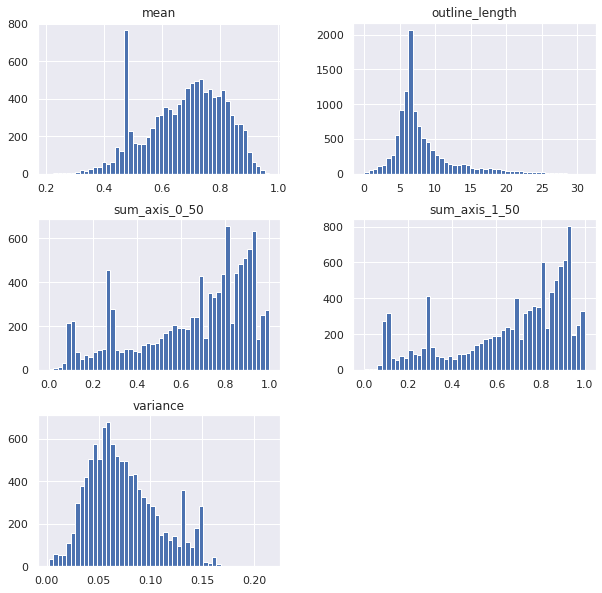

In [8]:
data[['sum_axis_0_50','sum_axis_1_50','mean','variance', 'outline_length']].hist(figsize=(10, 10), bins=50, layout=(3, 2));

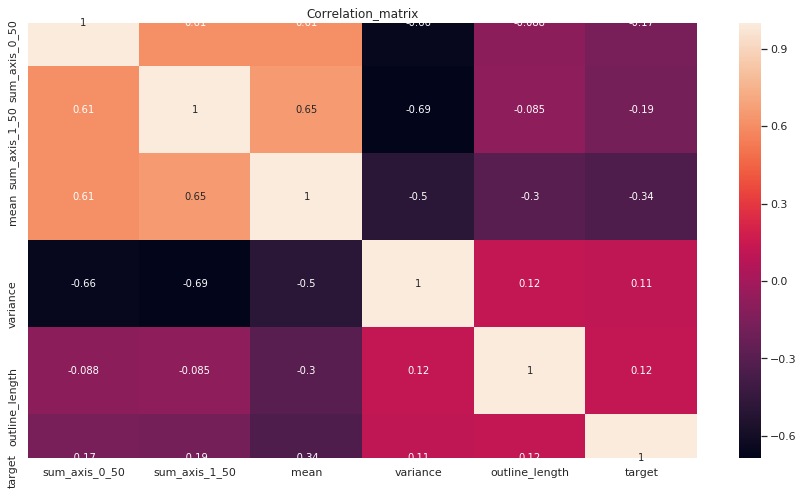

In [9]:
from sklearn import preprocessing
data_target = data.copy()
le = preprocessing.LabelEncoder()
data_target.target = le.fit_transform(data_target.target.values)
fig = plt.figure(figsize=(15,8))
sns.heatmap(data_target[['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length','target']].corr(), annot = True)
plt.title('Correlation_matrix')
plt.show()

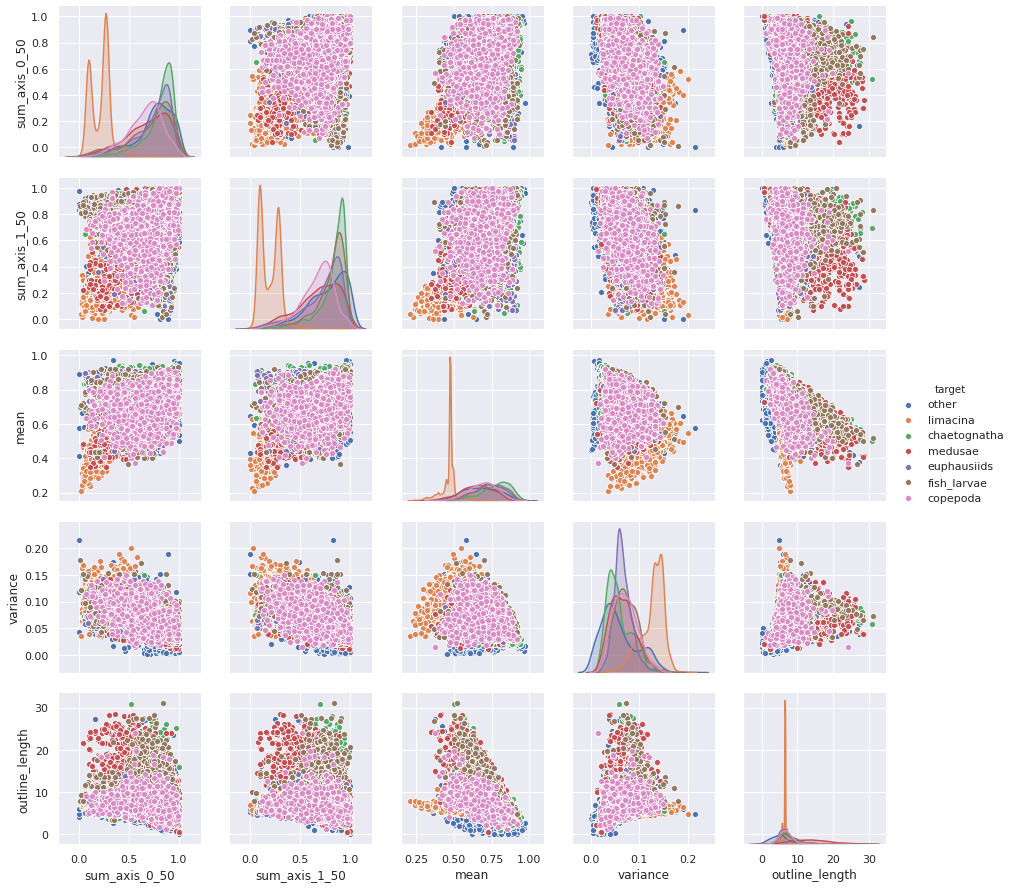

In [10]:
sns.pairplot(data,hue='target',vars=['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length'])
plt.show()

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
</div>

In [11]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/public_data/plankton_public.info
DataManager : plankton
info:
	usage = Sample dataset plankton data
	name = plankton
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 202
	target_num = 7
	label_num = 7
	train_num = 10752
	valid_num = 3584
	test_num = 3584
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(10752, 203)
	Y_train = array(10752, 1)
	X_valid = array(3584, 203)
	Y_valid = array(0,)
	X_test = array(3584, 203)
	Y_test = array(0,)
feat_type:	array(202,)
feat_idx:	array(0,)



<div style="background:#ff333c">
    APPEL DES MODELES : model.py et preprocess.py : 
</div>

In [12]:
from data_io import write
import preprocess as prepro
import numpy as np
import pickle
import numpy as np   # We recommend to use numpy arrays
from os.path import isfile
from sklearn.base import BaseEstimator
from libscores import get_metric
from data_manager import DataManager
import matplotlib
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

import preprocess as Prepro

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

<div style="background:#ff333c">
    On importe tous les différents modèles afin de les comparer 
</div>

<div style="background:#ff333c">
    Petite modification dans la classe model.py : pour pouvoir faire tourner plusieurs classifiers et effectuer des comparaisons de résultats
</div>

In [13]:
"""
Created on Sat Apr 4 
Last revised: Apr 5, 2020

@author: Antoine Barbannaud, Minh Kha Nguyen

This class is based on zClassifier.py by Isabelle Guyon.
This class contains the classifier with the integration of a preprocesor
"""
"""model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
data_dir = 'public_data'          
data_name = 'plankton'"""



class model(BaseEstimator):
    '''Class based on MonsterClassifier'''
    def __init__(self, classifier):   #on met le classifier en paramètre pour pouvoir l'appeler avec différents modèles
        #self.mdl = RandomForestClassifier(n_estimators=136, max_depth=None, min_samples_split=2, random_state=0)
        self.mdl = classifier
        self.num_train_samples=0
        self.num_feat=1
        self.num_labels=1
        self.prep = prepro.Preprocessor()
        
    def fit(self, X, y):
        ''' This is the training method: parameters are adjusted with training data.'''
        #1, y1 = self.prep.fit_transform(X)
        X1 = self.prep.fit_transform(X, y)
        return self.mdl.fit(X1, y)

    def predict(self, X):
        ''' This is called to make predictions on test data. Predicted classes are output.'''
        X1 = self.prep.transform(X)
        return self.mdl.predict(X1)

    def predict_proba(self, X):
        ''' Similar to predict, but probabilities of belonging to a class are output.'''
        return self.mdl.predict_proba(X) # The classes are in the order of the labels returned by get_classes
        
    def save(self, path="./"):
        file = open(path + '_model.pickle', "wb")
        pickle.dump(self, file)
        file.close()

    def load(self, path="./"):
        modelfile = path + '_model.pickle'
        if isfile(modelfile):
            with open(modelfile, 'rb') as f:
                self = pickle.load(f)
            print("Model reloaded from: " + modelfile)
        file.close()
        return self

<div style="background:#ff333c">
    Tableaux de déclarations de variables:
</div>

In [14]:
classifier = [DecisionTreeClassifier(max_depth=10),
        KNeighborsClassifier(1),
        ExtraTreesClassifier(),
        RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=1),
        AdaBoostClassifier(),
        QuadraticDiscriminantAnalysis()]

nomClass = ["DecisionTreeClassifier","KNeighborsClassifier","ExtraTreesClassifier","RandomForestClassifier","AdaBoostClassifier","QuadraticDiscriminantAnalysis"]

labels = ["chaetognatha","copepoda","euphausiids","fish_larvae","limacina","medusae","other"]

<div style="background:#ff333c">
    Prepocessing : "avant"
</div>

In [15]:
D = DataManager(data_name, data_dir)  # Load data
print("*** Original data ***")
print(D)
X_train = D.data['X_train']
Y_train = D.data['Y_train'].ravel()
X_test_sansModif = D.data['X_test']
X_pour_train = D.data['X_train'] 
X_pour_valid = D.data['X_valid']
X_pour_test = D.data['X_test']

Info file found : /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/public_data/plankton_public.info
*** Original data ***
DataManager : plankton
info:
	usage = Sample dataset plankton data
	name = plankton
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 202
	target_num = 7
	label_num = 7
	train_num = 10752
	valid_num = 3584
	test_num = 3584
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(10752, 203)
	Y_train = array(10752, 1)
	X_valid = array(3584, 203)
	Y_valid = array(0,)
	X_test = array(3584, 203)
	Y_test = array(0,)
feat_type:	array(202,)
feat_idx:	array(0,)



<div style="background:#ff333c">
    Prepocessing : mise en place :
</div>

In [16]:
Prepro = Prepro.Preprocessor()

# Preprocess on the data and load it back into D
D.data['X_train'] = Prepro.fit_transform(D.data['X_train'], D.data['Y_train'])
D.data['X_valid'] = Prepro.transform(D.data['X_valid'])
D.data['X_test'] = Prepro.transform(D.data['X_test'])
D.feat_name = np.array(['PC1', 'PC2'])
D.feat_type = np.array(['Numeric', 'Numeric'])

# Here show something that proves that the preprocessing worked fine
print("*** Transformed data ***")
print(D)


*** Transformed data ***
DataManager : plankton
info:
	usage = Sample dataset plankton data
	name = plankton
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 202
	target_num = 7
	label_num = 7
	train_num = 10752
	valid_num = 3584
	test_num = 3584
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(10752, 10)
	Y_train = array(10752, 1)
	X_valid = array(3584, 10)
	Y_valid = array(0,)
	X_test = array(3584, 10)
	Y_test = array(0,)
feat_type:	array(2,)
feat_idx:	array(0,)



<div style="background:#ff333c">
    Preprocessing : "après" 
</div>

In [17]:
X_train_prepo = D.data['X_train']
Y_train_prepo = D.data['Y_train'].ravel()
X_pour_train_prepo = D.data['X_train'] 
X_pour_valid_prepo = D.data['X_valid']
X_pour_test_prepo = D.data['X_test']

In [18]:
print(X_train_prepo.shape)

(10752, 10)


<div style="background:#ff333c">
    Modeling : 
</div>

In [19]:
Y_hat_train = []
Y_hat_valid = []
Y_hat_test = []

for i in range (len(classifier)):
    mdl = model(classifier[i])
    
    X_train_bosse = X_train.copy()
    Y_train_bosse = Y_train.copy()
    X1 = X_pour_train.copy()
    X2 = X_pour_valid.copy()
    X3 = X_pour_test .copy()
    
    mdl.fit(X_train_bosse, Y_train_bosse)
    
    #test de la prediction
    Y_hat_train.append(mdl.predict(X1))
    Y_hat_valid.append(mdl.predict(X2))
    Y_hat_test.append(mdl.predict(X3))
    print("Finish :" ,i, " sur ", (len(classifier)-1) )

Finish : 0  sur  5
Finish : 1  sur  5
Finish : 2  sur  5
Finish : 3  sur  5
Finish : 4  sur  5
Finish : 5  sur  5


<div style="background:#ff333c">
    Methode TSNE :
    <br>  * Première ligne : sans preprocessing</br>
    <br>  * Deuxième ligne : avec preprocessing</br>
</div>

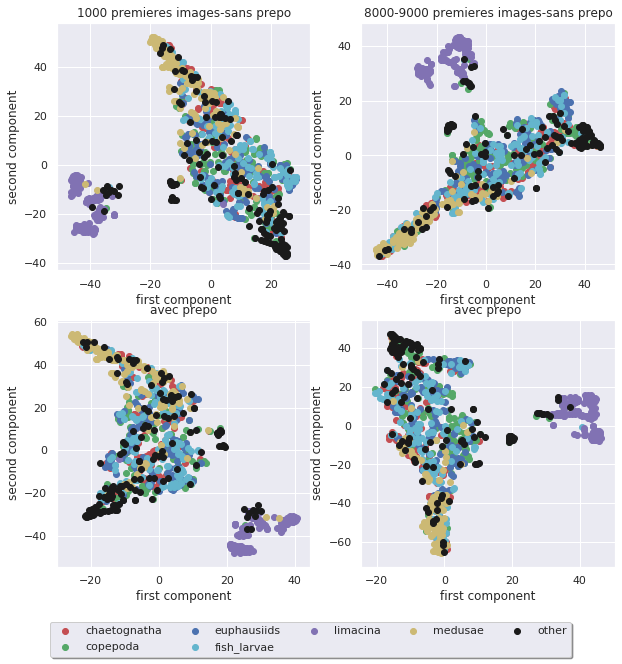

In [20]:
from sklearn.manifold import TSNE

fig,ax = plt.subplots(2,2, figsize=(10,10))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
target = range(len(labels))

#Fit and transform with a TSNE
tsne = TSNE(n_components=2,  random_state=0) #init='pca', -> entre les 2 deja ds le tsne

#Load the data - Sans Preprocessing
X = X_train[:1000]
Y = Y_train[:1000]
#Project the data in 2D
X_2d = tsne.fit_transform(X)

Xprime = X_train[8000:9000]
Yprime = Y_train[8000:9000]
X_2dprime = tsne.fit_transform(Xprime)

for i, color in zip(range(len(labels)), colors):
    #Sans prépro
    #Premiere figure
    idx = np.where(Y == i)
    ax[0][0].scatter(X_2d[idx, 0], X_2d[idx, 1], c=color, label=labels[i])
    #Deuxieme figure
    idx2 = np.where(Yprime == i)
    ax[0][1].scatter(X_2dprime[idx2, 0], X_2dprime[idx2, 1], c=color, label=labels[i])

ax[0][0].set_title("1000 premieres images-sans prepo")
ax[0][0].set_xlabel("first component")
ax[0][0].set_ylabel("second component")
ax[0][1].set_title("8000-9000 premieres images-sans prepo")
ax[0][1].set_xlabel("first component")
ax[0][1].set_ylabel("second component")
    
    
#Load the data - Preprocessing
Xprepo = X_train_prepo[:1000]
Yprepo = Y_train_prepo[:1000]
#Project the data in 2D
X_2dprepo = tsne.fit_transform(Xprepo)

XprimePrepo = X_train_prepo[8000:9000]
YprimePrepo = Y_train_prepo[8000:9000]
X_2dprimePrepo = tsne.fit_transform(XprimePrepo)

for i, color in zip(range(len(labels)), colors):
    #Avec prépro
    #Premiere figure
    idx = np.where(Y == i)
    ax[1][0].scatter(X_2dprepo[idx, 0], X_2dprepo[idx, 1], c=color, label=labels[i])
    #Deuxieme figure
    idx2 = np.where(Yprime == i)
    ax[1][1].scatter(X_2dprimePrepo[idx2, 0], X_2dprimePrepo[idx2, 1], c=color, label=labels[i])

ax[1][0].set_title("avec prepo")
ax[1][0].set_xlabel("first component")
ax[1][0].set_ylabel("second component")
ax[1][1].set_title("avec prepo")
ax[1][1].set_xlabel("first component")
ax[1][1].set_ylabel("second component")
ax[1][0].legend(loc='upper center', bbox_to_anchor=(1,-0.2),fancybox=True,shadow=True,ncol=5)

<div style="background:#ff333c">
    On remarque sur ces quatre graphiques obtenus, qui traite des images à deux endroits différents du tableau X_train (avec et sans preprocessing), que les limacinas sont les "mieux classés" et que les autres planctons se melangent. On peut supposer qu'ils ont plus de ressemblances et sont plus difficile à séparer
</div>

<div style="background:#AAAAAA">
    Code rajouter : Visualize cluster in your data 
</div>

In [21]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

<div style="background:#ff333c">
    Travail kmeans sans prépocessing :
</div>

In [22]:
#on prend nos donnees X_train
data = scale(X_train)
n_samples, n_features = data.shape 
n_digits = len(np.unique(Y_train)) #et nos valeurs dans Y_train

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].           

n_digits: 7, 	 n_samples 10752, 	 n_features 203


(10752, 2)


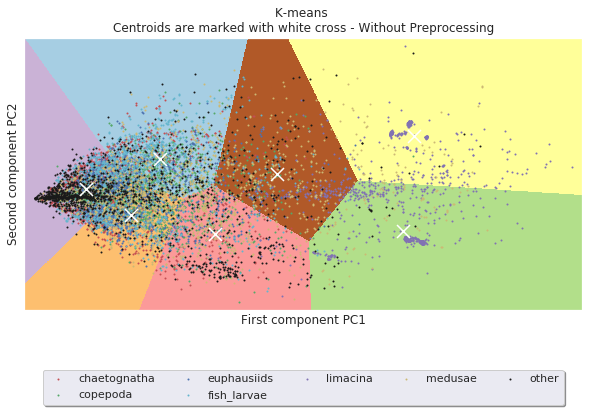

In [23]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(1, figsize=(10,5))


ax.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

for i, color in zip(range(len(labels)), colors):
    #Premiere figure
    idx = np.where(Y_train == i)
    ax.scatter(reduced_data[idx, 0], reduced_data[idx, 1], s=4, c=color, marker = '.', label=labels[i])
    

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
ax.set_title('K-means \n'
          'Centroids are marked with white cross - Without Preprocessing')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
ax.set_xlabel("First component PC1")
ax.set_ylabel("Second component PC2")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,shadow=True,ncol=5)
print(reduced_data.shape)

<div style="background:#ff333c">
    Travail kmeans avec prépocessing :
</div>

n_digits: 7, 	 n_samples 10752, 	 n_features 10
(10752, 2)


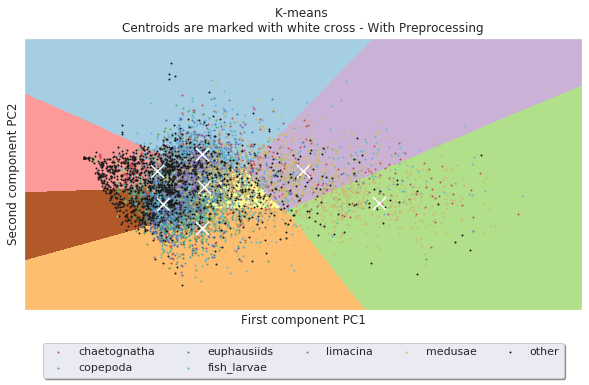

In [24]:
#on prend nos donnees X_train
data = scale(X_train_prepo)

n_samples, n_features = data.shape 
n_digits = len(np.unique(Y_train_prepo)) #et nos valeurs dans Y_train

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

        
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(1, figsize=(10,5))


ax.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

for i, color in zip(range(len(labels)), colors):
    #Premiere figure
    idx = np.where(Y_train_prepo == i)
    ax.scatter(reduced_data[idx, 0], reduced_data[idx, 1], s=4, c=color, marker = '.', label=labels[i])



# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
ax.set_title('K-means \n'
          'Centroids are marked with white cross - With Preprocessing')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
ax.set_xlabel("First component PC1")
ax.set_ylabel("Second component PC2")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),fancybox=True,shadow=True,ncol=5)
print(reduced_data.shape)

<div style="background:#ff333c">
    La cellule suivante peut nous etre utile pour la visu car elle permt de visualiser 1000 images en 
    1000 images et de voir la répartition des données
</div>

In [25]:
"""for i in range(0,10000, 1000):
    data1 = scale(X_train[i:i+1000])
    n_samples, n_features = data1.shape 
    n_digits = len(np.unique(Y_train[i:i+1000])) #et nos valeurs dans Y_train

    print("n_digits: %d, \t n_samples %d, \t n_features %d"
          % (n_digits, n_samples, n_features))
          
    # Visualize the results on PCA-reduced data

    reduced_data1 = PCA(n_components=2).fit_transform(data1)
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data1)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data1[:, 0].min() - 1, reduced_data1[:, 0].max() + 1
    y_min, y_max = reduced_data1[:, 1].min() - 1, reduced_data1[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data1[:, 0], reduced_data1[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means with reduced data from '+str(i)+' to '+str(i+1000)+ '\n'
              'Centroids are marked with white cross')
    #ax[1].set_xlim(x_min, x_max)
    #ax[1].set_ylim(y_min, y_max)
    #ax[1].set_xticks(())
    #ax[1].set_yticks(())
    plt.pause(0.1)




print(reduced_data1)
print(reduced_data1.shape)"""

'for i in range(0,10000, 1000):\n    data1 = scale(X_train[i:i+1000])\n    n_samples, n_features = data1.shape \n    n_digits = len(np.unique(Y_train[i:i+1000])) #et nos valeurs dans Y_train\n\n    print("n_digits: %d, \t n_samples %d, \t n_features %d"\n          % (n_digits, n_samples, n_features))\n          \n    # Visualize the results on PCA-reduced data\n\n    reduced_data1 = PCA(n_components=2).fit_transform(data1)\n    kmeans = KMeans(init=\'k-means++\', n_clusters=n_digits, n_init=10)\n    kmeans.fit(reduced_data1)\n\n    # Step size of the mesh. Decrease to increase the quality of the VQ.\n    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].\n\n    # Plot the decision boundary. For that, we will assign a color to each\n    x_min, x_max = reduced_data1[:, 0].min() - 1, reduced_data1[:, 0].max() + 1\n    y_min, y_max = reduced_data1[:, 1].min() - 1, reduced_data1[:, 1].max() + 1\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))\n\n

Chaque cluster correspond à un "type" de plancton différents
On remarque que certains points sont très rapproches, on a du mal a les separer, les discerner. Tandis que d'autres sont plus "espaces" et sont plus facile a reconnaitre

Nous avons creer un second graphique en reduisant nos donnees pour que ce soit plus lisible. On a pris les 5000 premieres images

<div style="background:#AAAAAA">
    Code rajouter : Visualize cluster in your data. On a reduit le nombre de valeurs pour que ce soit plus lisible
</div>

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [26]:
'''
# uncomment the desired model

# Decision tree model
from sklearn.tree import DecisionTreeClassifier
M = model(classifier=DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42))

trained_model_name = model_dir + data_name

# Uncomment the next line to re-load an already trained model
M = model()
M = M.load(trained_model_name)     
'''

"\n# uncomment the desired model\n\n# Decision tree model\nfrom sklearn.tree import DecisionTreeClassifier\nM = model(classifier=DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42))\n\ntrained_model_name = model_dir + data_name\n\n# Uncomment the next line to re-load an already trained model\nM = model()\nM = M.load(trained_model_name)     \n"

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [27]:
'''
X_train = D.data['X_train']
Y_train = D.data['Y_train']

if not(M.is_trained):
    M.fit(X_train, Y_train)
    print('training')

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])
'''

"\nX_train = D.data['X_train']\nY_train = D.data['Y_train']\n\nif not(M.is_trained):\n    M.fit(X_train, Y_train)\n    print('training')\n\nY_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples\nY_hat_valid = M.predict(D.data['X_valid'])\nY_hat_test = M.predict(D.data['X_test'])\n"

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [28]:
#M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/plankton_test.predict
sample_result_submission/plankton_train.predict
sample_result_submission/plankton_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

<div style="background:#FFFFAA">
The chosen metric is the balanced accuracy. It computes the proportion of elements correctly predicted for each class. It then returns the mean of these values. The advantage of this metric is that every class is given an equal weight. <br> In our case, since all the classes are perfectly balanced, it is equivalent to simply computing the accuracy score but it the case the test set is changed and is no longer balanced, the balanced accuracy will still work properly while the accuracy score will not.
</div>

In [29]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: balanced_accuracy_score


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

<div style="background:#ff333c">
   Calcul du score pour chaque méthode:
</div>

In [30]:
for i in range (len(classifier)):
    print(nomClass[i], ":")
    print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train[i]))
    print()
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

DecisionTreeClassifier :
Training score for the balanced_accuracy_score metric = 0.6908

KNeighborsClassifier :
Training score for the balanced_accuracy_score metric = 0.9998

ExtraTreesClassifier :
Training score for the balanced_accuracy_score metric = 0.9998

RandomForestClassifier :
Training score for the balanced_accuracy_score metric = 0.9998

AdaBoostClassifier :
Training score for the balanced_accuracy_score metric = 0.4057

QuadraticDiscriminantAnalysis :
Training score for the balanced_accuracy_score metric = 0.4891

Ideal score for the balanced_accuracy_score metric = 1.0000


<div style="background:#ff333c">
   Matrice de confusion pour chaque methode:
</div>

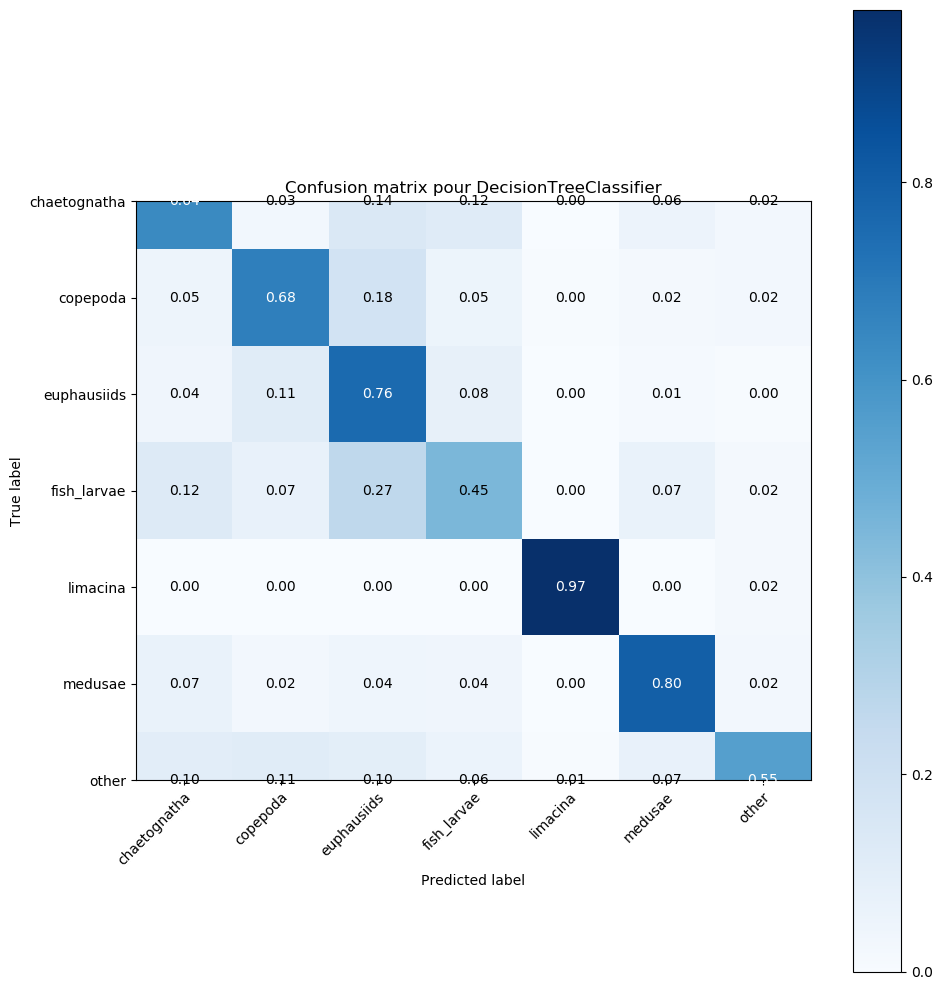

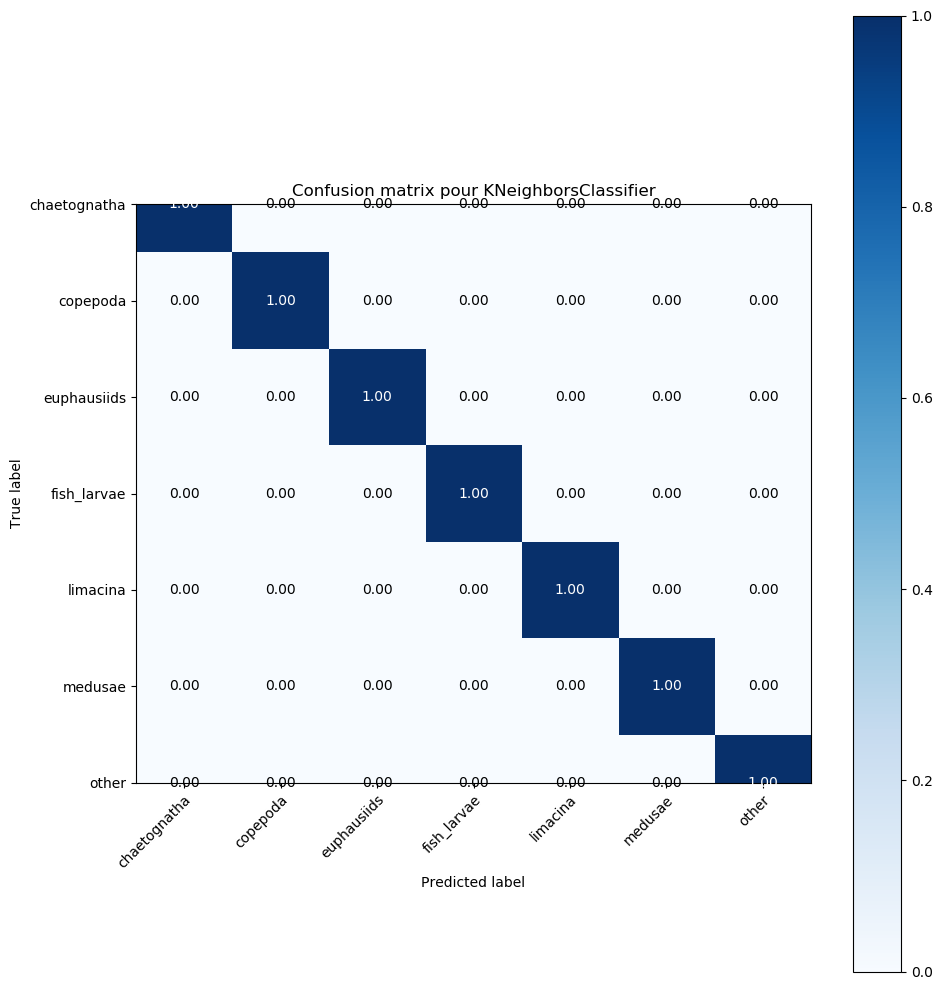

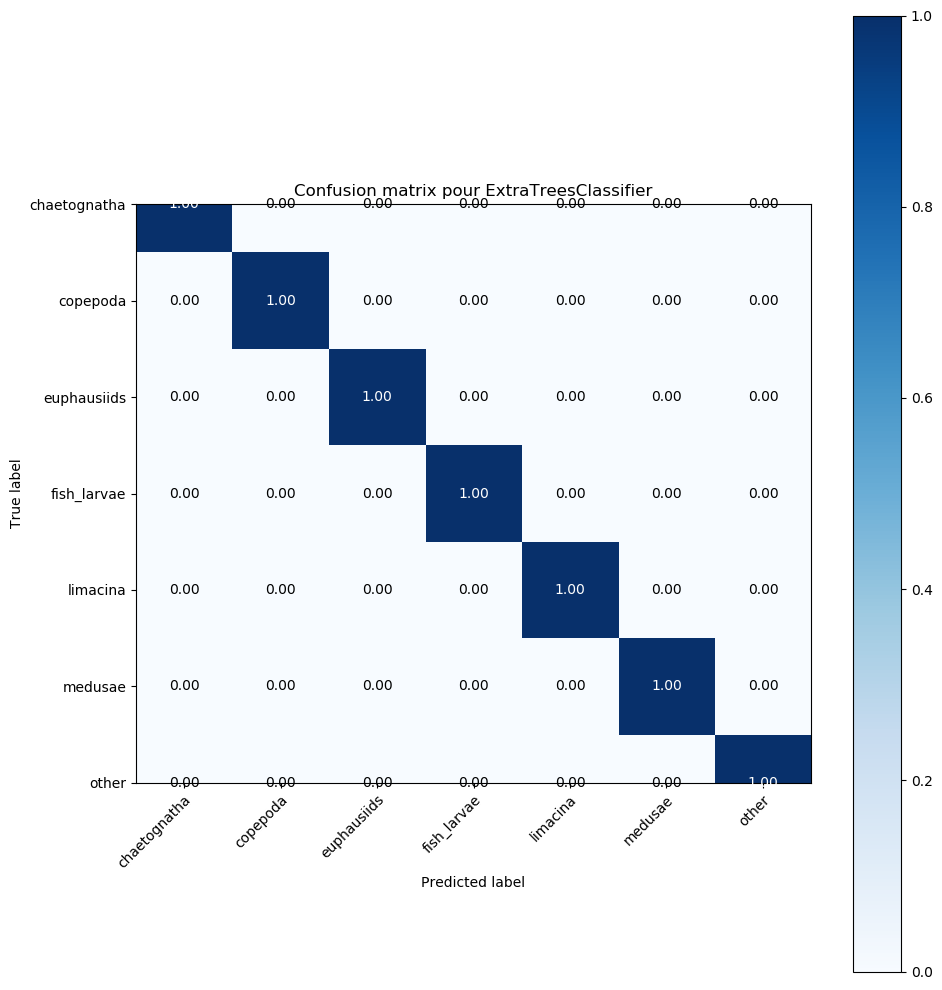

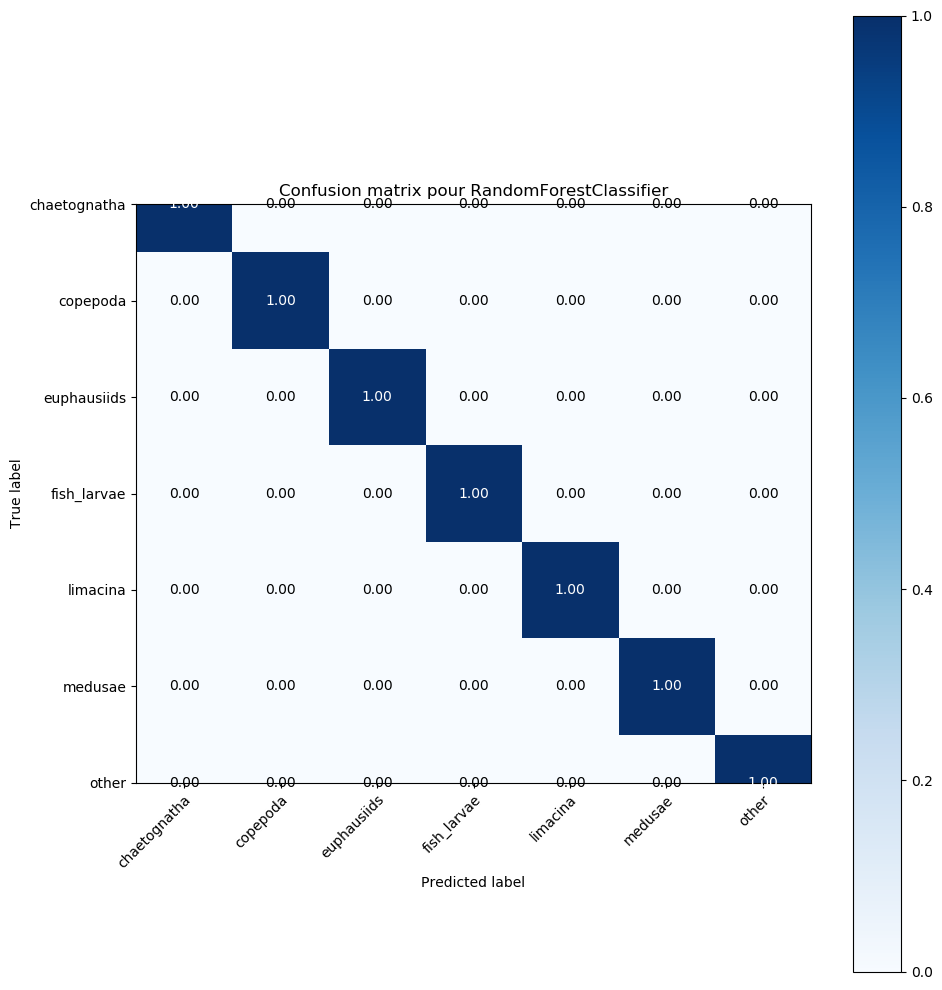

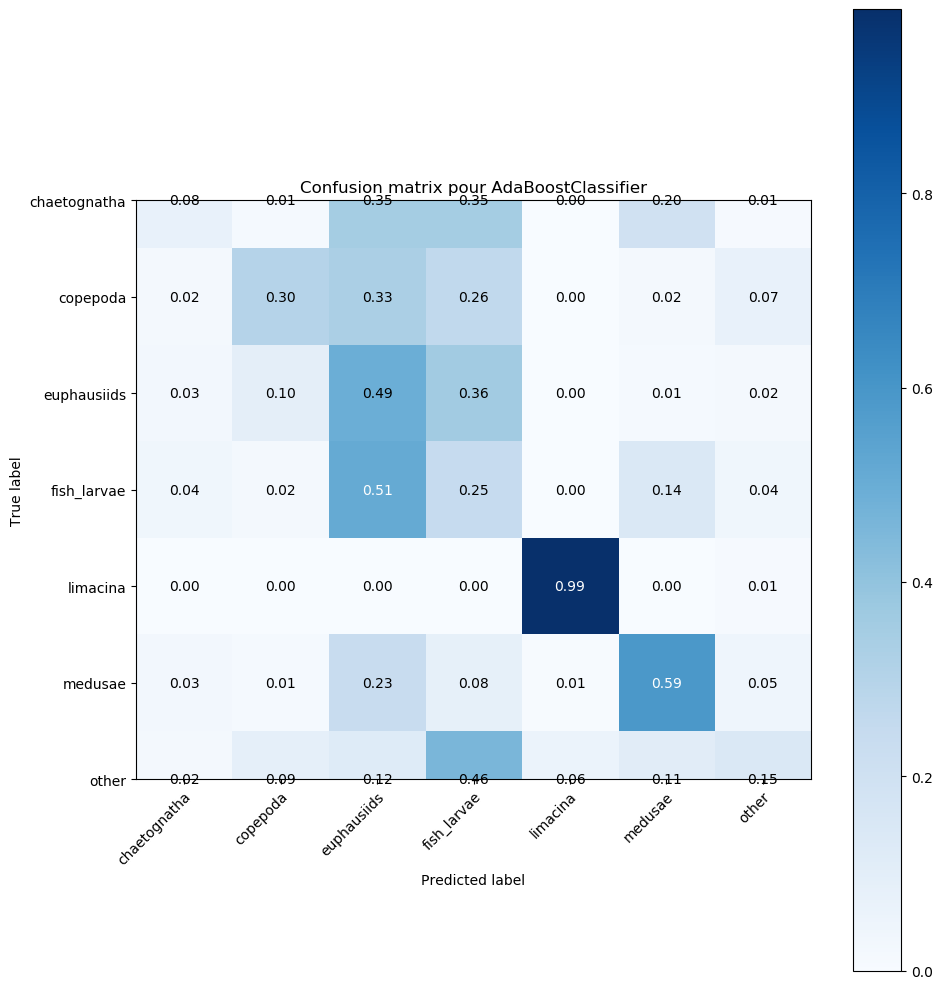

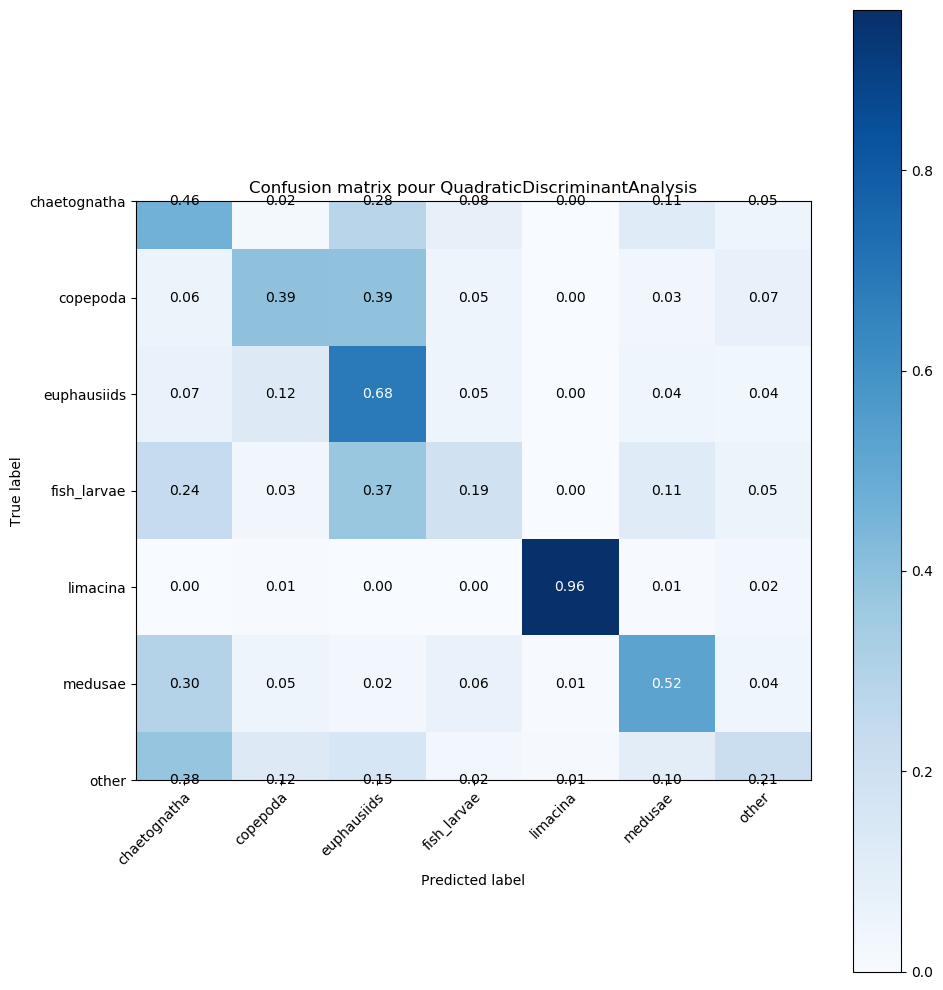

In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

for i in range (len(classifier)):
    plt.style.use('default')
    cm = confusion_matrix(Y_train, Y_hat_train[i])
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=labels,yticklabels=labels,title="Confusion matrix pour {}".format(nomClass[i]),xlabel="Predicted label",ylabel="True label")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

<div style="background:#AAAAAA">
    Code rajouter : Classifier - decision boundary
</div>

<div style="background:#ff333c">
   DecisionTree pour chaque methode:
</div>

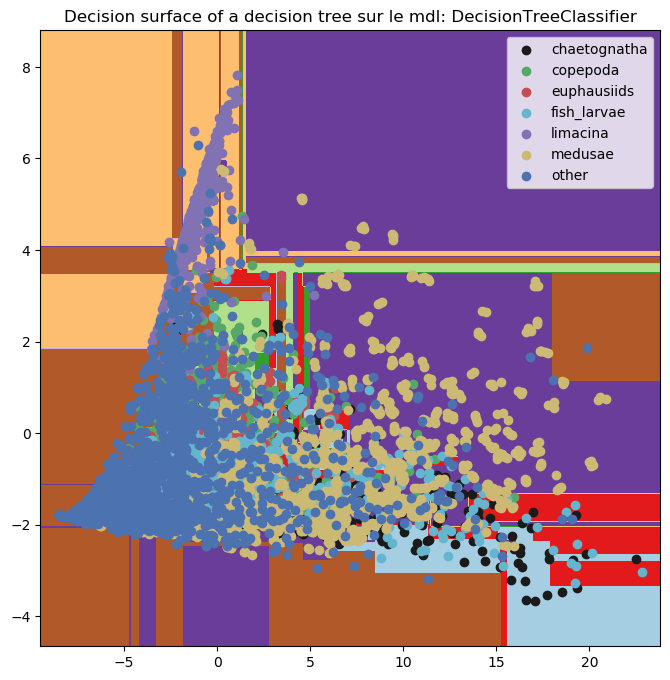

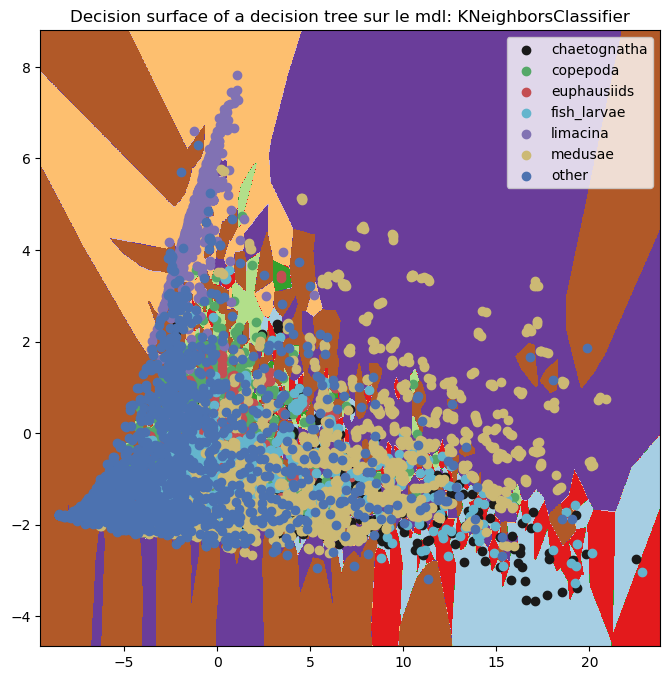

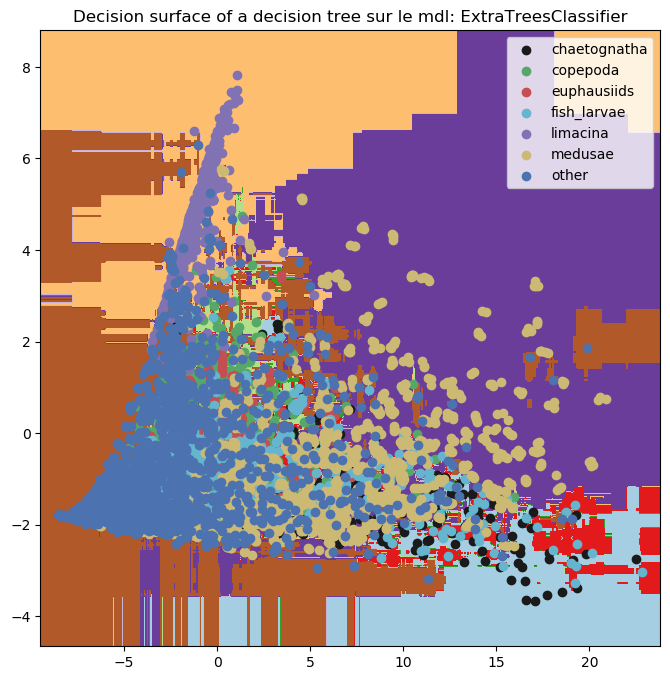

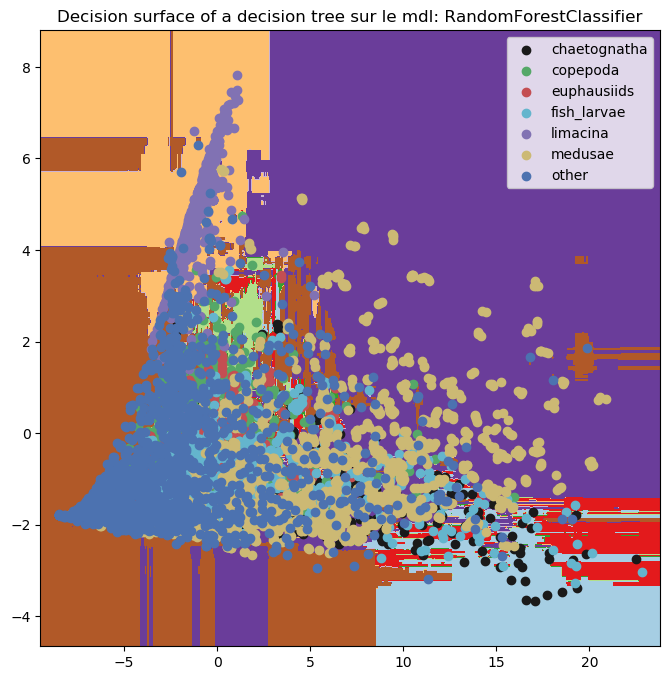

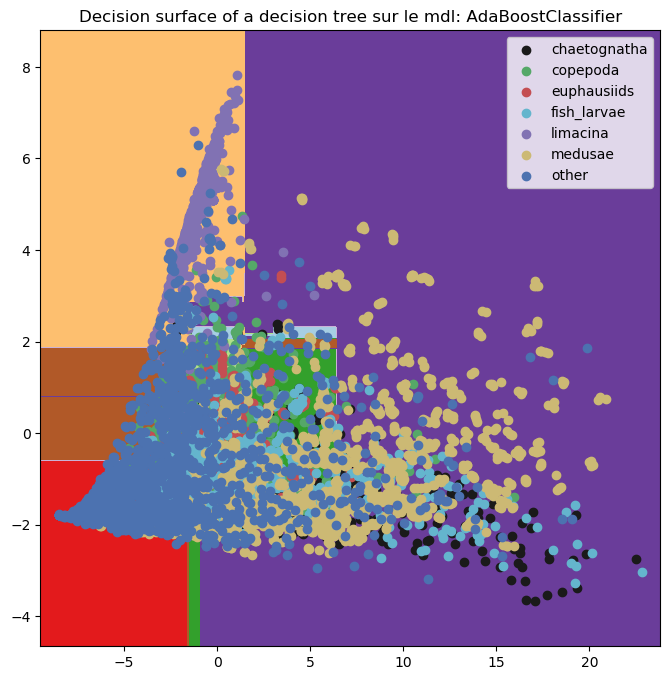

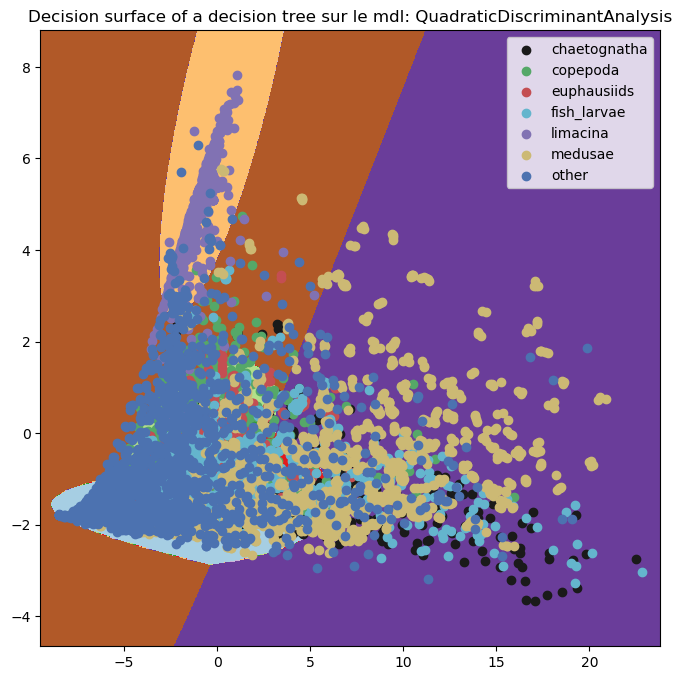

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 7
plot_colors = "kgrcmyb"

plot_step = 0.02

X = X_train
y = Y_train

X = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(X)

indice =0
for mdl in classifier:
    # Train
    clf = mdl.fit(X, y)


    # Plot the decision boundary
    plt.figure(figsize=(8,8))

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i])

    plt.axis("tight")
    plt.title("Decision surface of a decision tree sur le mdl: {}".format(nomClass[indice]))
    plt.legend()
    plt.show()
    indice +=1

On a reduit nos donnes en deux dimensions a l'aide du PCA. Puis nous avons trace les donnees obtenues

<div style="background:#AAAAAA">
    Code rajouter : Regressor - residual error
</div>

<div style="background:#ff333c">
   Arbre de décision pour chaque méthode:
</div>

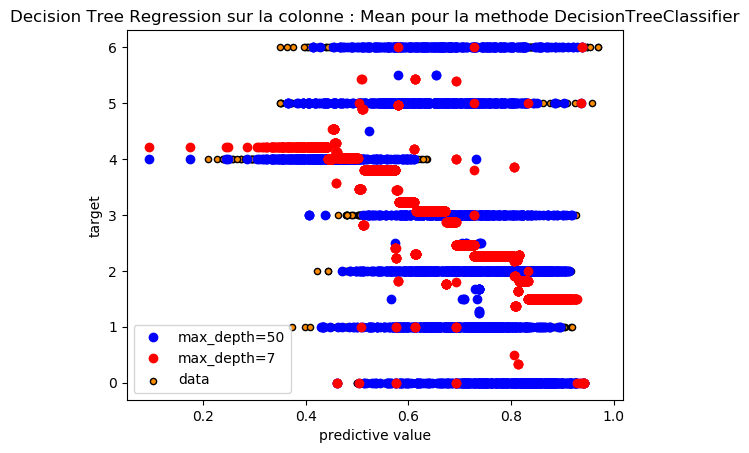

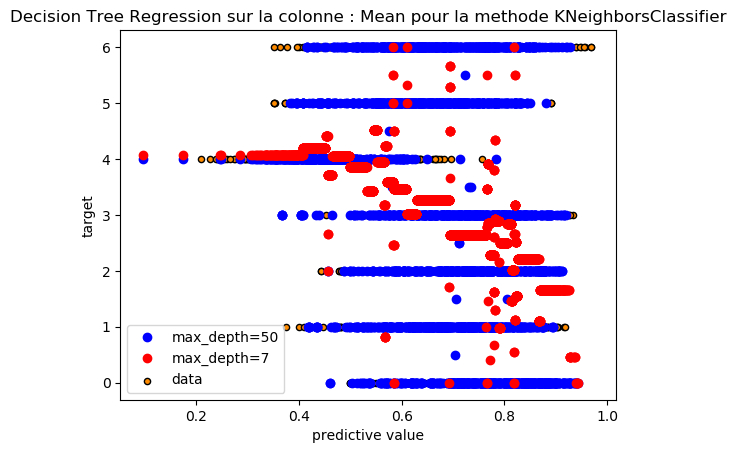

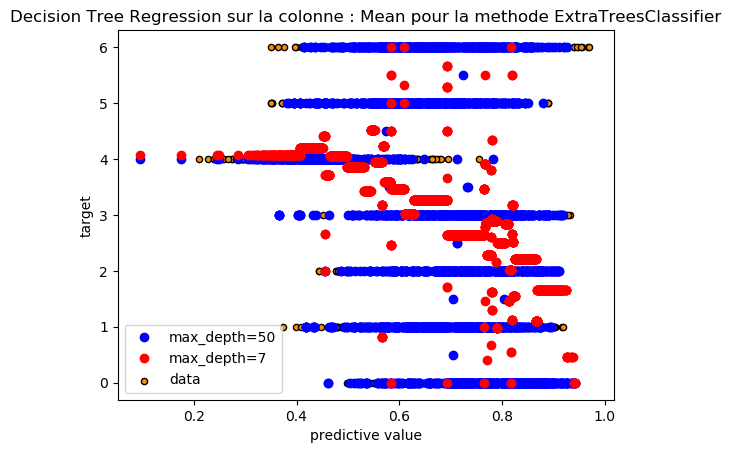

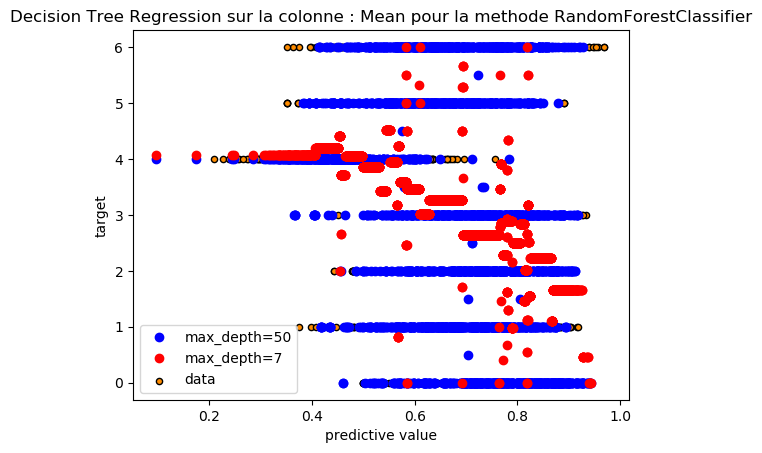

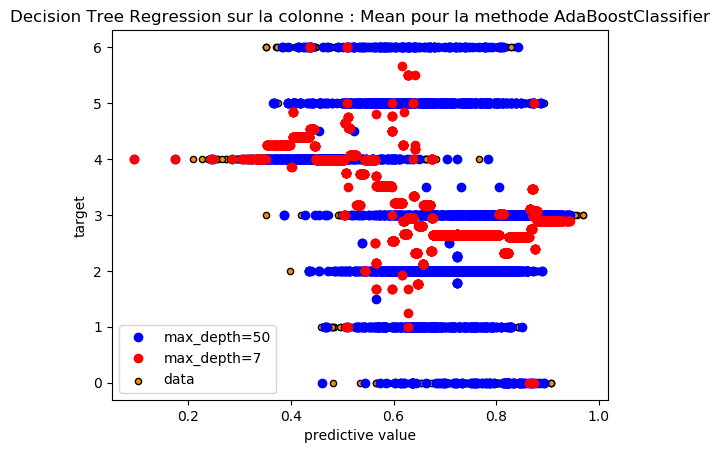

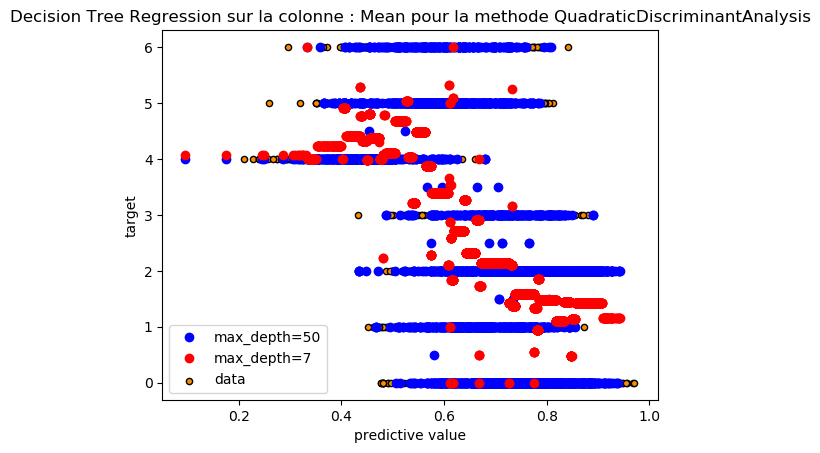

In [33]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a dataset
#on travaille sur une colonne de nos donnees 
colonne = 200 #correpond a la colonne mean
for i in range (len(classifier)):
    X = X_train[:, colonne][:, np.newaxis] 
    y = Y_hat_train[i]

    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=50)
    regr_2 = DecisionTreeRegressor(max_depth=7)
    regr_1.fit(X, y)
    regr_2.fit(X, y)

    # Predict
    X_test = X_test_sansModif[:, colonne][:, np.newaxis]
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)

    # Plot the results
    plt.figure()
    plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
    plt.plot(X_test, y_1, 'ro', color="blue", label="max_depth=50", linewidth=2)
    plt.plot(X_test, y_2, 'ro', color="red", label="max_depth=7", linewidth=2)
    plt.xlabel("predictive value")
    plt.ylabel("target")
    plt.title("Decision Tree Regression sur la colonne : Mean pour la methode {}".format(nomClass[i]))
    plt.legend()
    plt.show()

Travail sur la colonne mean: <p>
On observe sur le graphique précédent que plus la profondeur de l'arbre est faible plus le modele a du mal a "classer" nos donnees, avec max_depth=7, il commence a distinguer nos 7 types de plancton. Tandis que lorsque la profondeur augmente le modele repartit mieux les differents planctons. 

<div style="background:#ff333c">
   Code permettant de voir combien il y a d'erreurs entre Y_train et ce qu'on doit trouver
</div>

In [34]:
#Code permettant de voir combien il y a d'erreurs entre Y_train et ce qu'on doit trouver
for i in range (len(classifier)):
    print(nomClass[i])
    Y_error = Y_train.ravel() - Y_hat_train[i]
    Y_error = np.where(Y_error==0, Y_error, 1)
    diff = np.sum(Y_error)
    print("Nb différent :" ,diff)
    print("Training score", 1- diff/10752) # training score
    print()

DecisionTreeClassifier
Nb différent : 3324.0
Training score 0.6908482142857143

KNeighborsClassifier
Nb différent : 2.0
Training score 0.9998139880952381

ExtraTreesClassifier
Nb différent : 2.0
Training score 0.9998139880952381

RandomForestClassifier
Nb différent : 2.0
Training score 0.9998139880952381

AdaBoostClassifier
Nb différent : 6390.0
Training score 0.4056919642857143

QuadraticDiscriminantAnalysis
Nb différent : 5493.0
Training score 0.4891183035714286



<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

<div style="background:#ff333c">
   Tavail sur les scores obtenus :
</div>

In [35]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

scores = []

for mdl in classifier:
    scores.append(cross_val_score(mdl, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function)))

In [36]:
for i in range (len(classifier)):
    print(nomClass[i])
    print('CV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores[i].mean(), scores[i].std() * 2))
    print()

DecisionTreeClassifier
CV score (95 perc. CI): 0.62 (+/- 0.02)

KNeighborsClassifier
CV score (95 perc. CI): 0.71 (+/- 0.02)

ExtraTreesClassifier
CV score (95 perc. CI): 0.71 (+/- 0.03)

RandomForestClassifier
CV score (95 perc. CI): 0.78 (+/- 0.01)

AdaBoostClassifier
CV score (95 perc. CI): 0.40 (+/- 0.04)

QuadraticDiscriminantAnalysis
CV score (95 perc. CI): 0.46 (+/- 0.01)



<div style="background:#ff333c">
    Ajout test scores : on verifie que le score est inférieur à 1
</div>

In [37]:
def testScores (tabS):
    for i in range (len(tabS)):
        for val in tabS[i]:
            assert val < 1, "Scores n'est pas valable !!"
    print("Les scores sont corrects")

In [38]:
testScores(scores)

Les scores sont corrects


<div style="background:#AAAAAA">
    Code rajouter : Plot performance of machine learning model with error
</div>

In [39]:
print(scores)

[array([0.61085343, 0.61563518, 0.63099116, 0.61005119, 0.6216845 ]), array([0.6971243 , 0.6984644 , 0.71288972, 0.71986971, 0.70730572]), array([0.68877551, 0.69381107, 0.7254537 , 0.71009772, 0.71242438]), array([0.77782931, 0.77943229, 0.78780828, 0.78594695, 0.77617497]), array([0.40584416, 0.39087948, 0.3755235 , 0.41368078, 0.42717543]), array([0.46150278, 0.47045137, 0.46161005, 0.45835272, 0.46067939])]


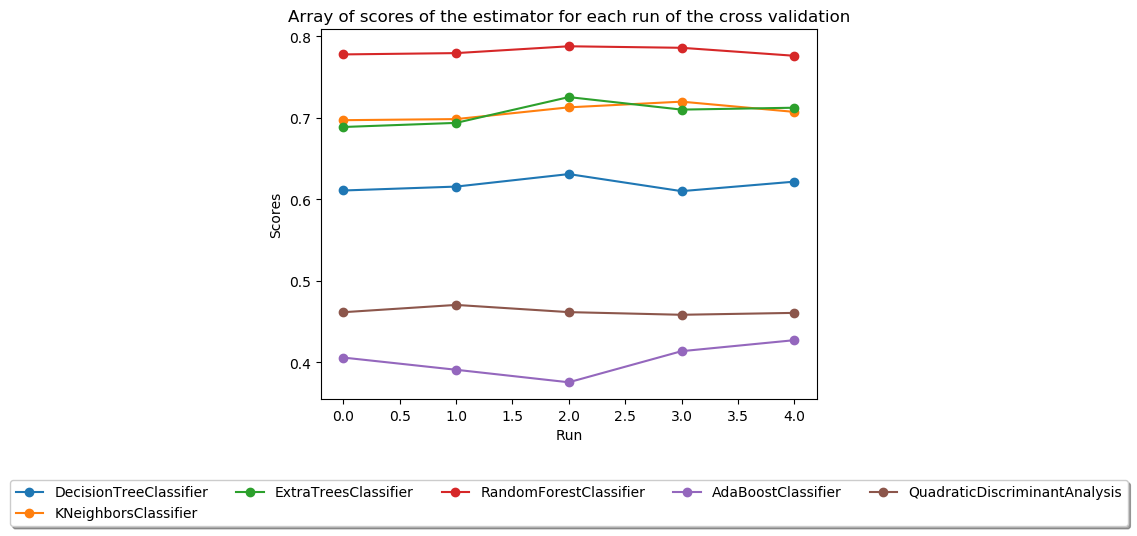

In [40]:
for i in range (len(scores)):
    plt.plot(scores[i], 'o-' ,label=nomClass[i])
plt.xlabel("Run")
plt.ylabel("Scores")
plt.title("Array of scores of the estimator for each run of the cross validation")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,shadow=True,ncol=5)

In [41]:
from sklearn.model_selection import learning_curve

train_sizes_tab = []
train_scores_tab = []
test_scores_tab = []
#numbers of training examples that will be used to generate the learning curve
# on commence a 2000 pour avoir assez de donnees et un score assez eleve
#size = np.linspace(2000,8601, num=10).astype(int)
i = 0
for mdl in classifier:
    #on lance la fonction sur nos donnees 
    #train_sizes, train_scores, test_scores = learning_curve(mdl, D.data['X_train'], D.data['Y_train'], train_sizes=size, cv=5, scoring=make_scorer(scoring_function))
    train_sizes, train_scores, test_scores = learning_curve(mdl, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    train_sizes_tab.append(train_sizes)
    train_scores_tab.append(train_scores)
    test_scores_tab.append(test_scores)
    print("Finish ", i, " sur ", (len(classifier)-1))
    i+=1

Finish  0  sur  5
Finish  1  sur  5
Finish  2  sur  5
Finish  3  sur  5
Finish  4  sur  5


/home/clemence/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/clemence/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/clemence/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/clemence/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/clemence/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/clemence/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("

Finish  5  sur  5


In [42]:
test_scores_mean = []
test_scores_std = []
for i in range (len(train_sizes_tab)):
    test_scores_mean.append(np.mean(test_scores_tab[i], axis=1))
    test_scores_std.append(np.std(test_scores_tab[i], axis=1))
    print("Finish ", i, " sur ", (len(train_sizes_tab)-1))

Finish  0  sur  5
Finish  1  sur  5
Finish  2  sur  5
Finish  3  sur  5
Finish  4  sur  5
Finish  5  sur  5


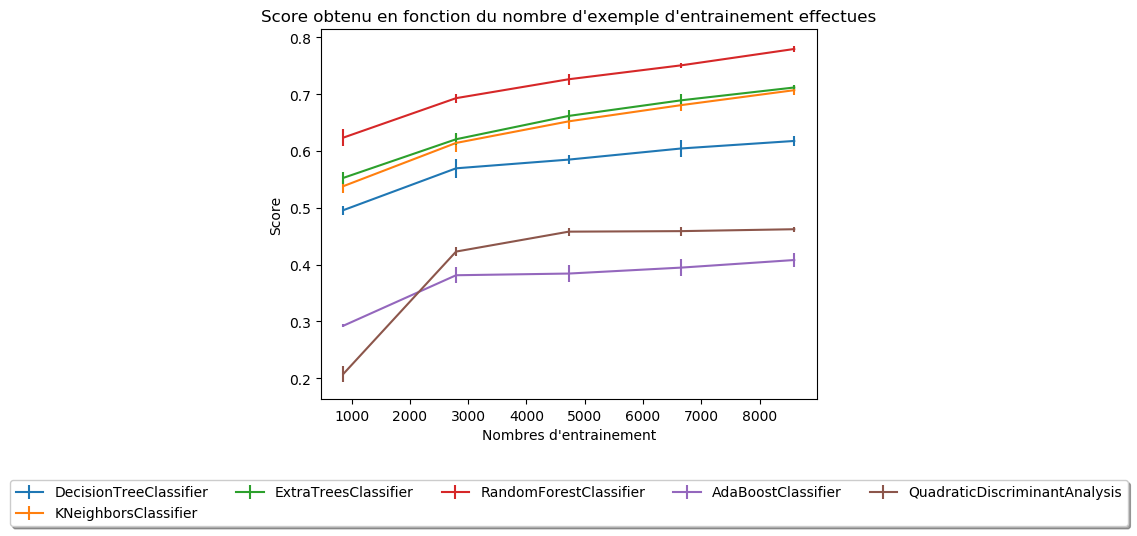

In [43]:
for i in range (len(test_scores_mean)):
    plt.errorbar(train_sizes_tab[i], test_scores_mean[i], test_scores_std[i], label=nomClass[i])
plt.xlabel("Nombres d'entrainement")
plt.ylabel("Score")
plt.title("Score obtenu en fonction du nombre d'exemple d'entrainement effectues")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,shadow=True,ncol=5)

De ce schema, on observe que environ 7867 donnes pour effectuer l'entrainement

<div style="background:#f7a310">
<br>Variation des parametres pour RandomForest: <br/>
 </div>

In [44]:
classifierEsti = [
        RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=1),
        RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=1),
        RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=1),
        RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, random_state=1),
        ]
labelsEsti = ["n_esti =50","n_esti =100","n_esti =116","n_esti =200"]

classifierDepth = [
        RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=1),
        RandomForestClassifier(n_estimators=116, max_depth=7, min_samples_split=2, random_state=1),
        RandomForestClassifier(n_estimators=116, max_depth=50, min_samples_split=2, random_state=1),
        RandomForestClassifier(n_estimators=116, max_depth=100, min_samples_split=2, random_state=1),
        ]
labelsDepth = ["max_depth = None","max_depth = 7","max_depth = 50","max_depth = 100"]

classifierRandom = [
        RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=0),
        RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=1),
        RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=5),
        RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=2),
        ]
labelsRandom = ["random_state=0","random_state=1","random_state=5","random_state=2"]



nomClass = ["DecisionTreeClassifier","KNeighborsClassifier","ExtraTreesClassifier","RandomForestClassifier","AdaBoostClassifier","QuadraticDiscriminantAnalysis"]
labels = ["chaetognatha","copepoda","euphausiids","fish_larvae","limacina","medusae","other"]

In [45]:
from data_manager import DataManager
from libscores import get_metric
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

def varierPara(tab, tabLegend):
    D = DataManager(data_name, data_dir, replace_missing=True)
    X_train = D.data['X_train']
    Y_train = D.data['Y_train'].ravel()
    X_test_sansModif = D.data['X_test']
    X_pour_train = D.data['X_train'] 
    X_pour_valid = D.data['X_valid']
    X_pour_test = D.data['X_test']
    Y_hat_train = []
    Y_hat_valid = []
    Y_hat_test = []
    
    
    for i in range (len(tab)):
        mdl = model(tab[i])
        X_train_bosse = X_train.copy()
        Y_train_bosse = Y_train.copy()
        X1 = X_pour_train.copy()
        X2 = X_pour_valid.copy()
        X3 = X_pour_test .copy()
        mdl.fit(X_train_bosse, Y_train_bosse)
        #test de la prediction
        Y_hat_train.append(mdl.predict(X1))
        Y_hat_valid.append(mdl.predict(X2))
        Y_hat_test.append(mdl.predict(X3))
        print("Finish :" ,i, " sur ", (len(tab)-1) )

    print("Fin initialisation\n")
    for i in range (len(tab)):
        print(tabLegend[i], ":")
        print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train[i]))
        print()
    print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
    print('FIn score\n')
   

    scores = []
    for mdl in tab:
        scores.append(cross_val_score(mdl, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function)))
    testScores(scores)
    print("Fin init tab scores")
    for i in range (len(tab)):
        print(tabLegend[i])
        print('CV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores[i].mean(), scores[i].std() * 2))
        print()

    for i in range (len(scores)):
        plt.plot(scores[i], 'o-' ,label=tabLegend[i])
    plt.xlabel("Run")
    plt.ylabel("Scores")
    plt.title("Array of scores of the estimator for each run of the cross validation")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,shadow=True,ncol=5)

Using scoring metric: balanced_accuracy_score


Info file found : /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/public_data/plankton_public.info
Finish : 0  sur  3
Finish : 1  sur  3
Finish : 2  sur  3
Finish : 3  sur  3
Fin initialisation

n_esti =50 :
Training score for the balanced_accuracy_score metric = 0.9998

n_esti =100 :
Training score for the balanced_accuracy_score metric = 0.9998

n_esti =116 :
Training score for the balanced_accuracy_score metric = 0.9998

n_esti =200 :
Training score for the balanced_accuracy_score metric = 0.9998

Ideal score for the balanced_accuracy_score metric = 1.0000
FIn score

Les scores sont corrects
Fin init tab scores
n_esti =50
CV score (95 perc. CI): 0.77 (+/- 0.02)

n_esti =100
CV score (95 perc. CI): 0.78 (+/- 0.01)

n_esti =116
CV score (95 perc. CI): 0.78 (+/- 0.01)

n_esti =200
CV score (95 perc. CI): 0.78 (+/- 0.01)



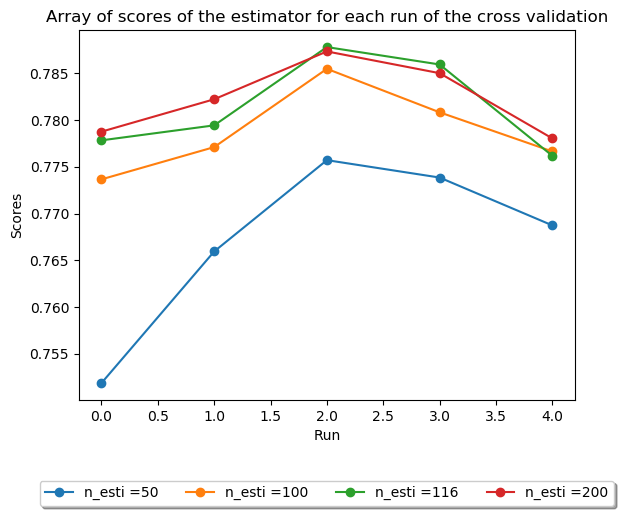

In [46]:
varierPara(classifierEsti, labelsEsti)

Info file found : /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/public_data/plankton_public.info
Finish : 0  sur  3
Finish : 1  sur  3
Finish : 2  sur  3
Finish : 3  sur  3
Fin initialisation

max_depth = None :
Training score for the balanced_accuracy_score metric = 0.9998

max_depth = 7 :
Training score for the balanced_accuracy_score metric = 0.6434

max_depth = 50 :
Training score for the balanced_accuracy_score metric = 0.9998

max_depth = 100 :
Training score for the balanced_accuracy_score metric = 0.9998

Ideal score for the balanced_accuracy_score metric = 1.0000
FIn score

Les scores sont corrects
Fin init tab scores
max_depth = None
CV score (95 perc. CI): 0.78 (+/- 0.01)

max_depth = 7
CV score (95 perc. CI): 0.62 (+/- 0.02)

max_depth = 50
CV score (95 perc. CI): 0.78 (+/- 0.01)

max_depth = 100
CV score (95 perc. CI): 0.78 (+/- 0.01)



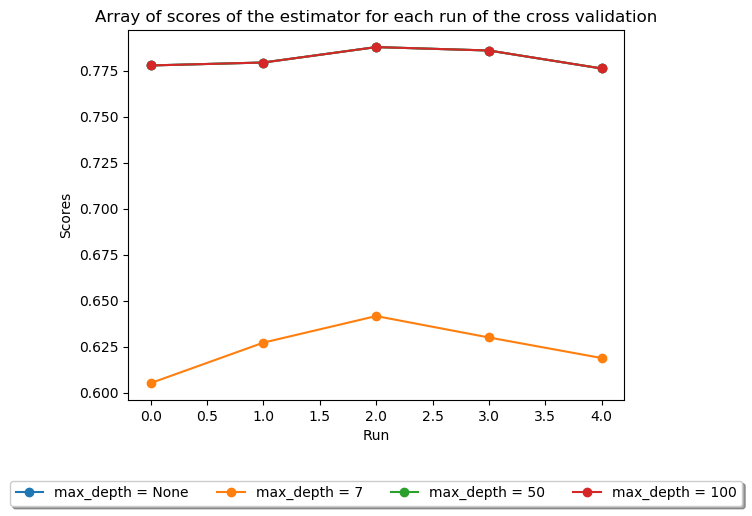

In [47]:
varierPara(classifierDepth, labelsDepth)

Info file found : /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/public_data/plankton_public.info
Finish : 0  sur  3
Finish : 1  sur  3
Finish : 2  sur  3
Finish : 3  sur  3
Fin initialisation

random_state=0 :
Training score for the balanced_accuracy_score metric = 0.9998

random_state=1 :
Training score for the balanced_accuracy_score metric = 0.9998

random_state=5 :
Training score for the balanced_accuracy_score metric = 0.9998

random_state=2 :
Training score for the balanced_accuracy_score metric = 0.9998

Ideal score for the balanced_accuracy_score metric = 1.0000
FIn score

Les scores sont corrects
Fin init tab scores
random_state=0
CV score (95 perc. CI): 0.78 (+/- 0.01)

random_state=1
CV score (95 perc. CI): 0.78 (+/- 0.01)

random_state=5
CV score (95 perc. CI): 0.78 (+/- 0.01)

random_state=2
CV score (95 perc. CI): 0.78 (+/- 0.01)



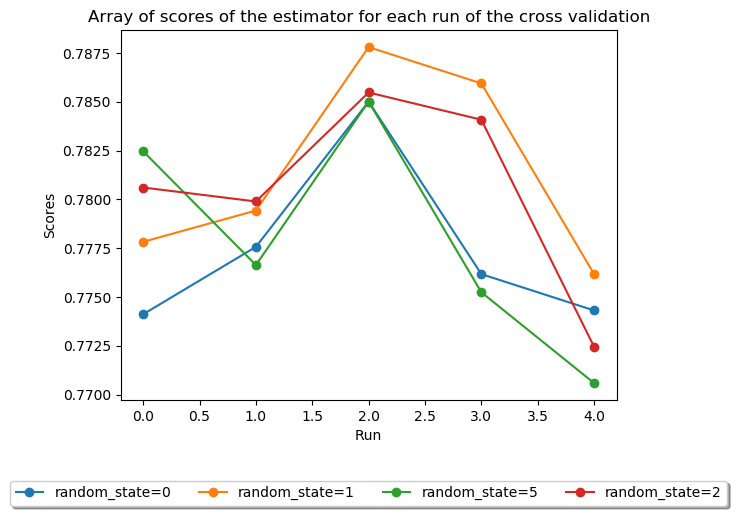

In [48]:
varierPara(classifierRandom, labelsRandom)

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [49]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

/bin/sh: 1: source: not found
Using input_dir: /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/public_data
Using output_dir: /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/sample_result_submission
Using program_dir: /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/ingestion_program
Using submission_dir: /home/clemence/L2/S4/Info232/ECOLO1/starting_kit/sample_code_submission
Traceback (most recent call last):
  File "ingestion_program//ingestion.py", line 140, in <module>
    from model import model    			 # example model, in scikit-learn style
ModuleNotFoundError: No module named 'model'


<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [50]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

/bin/sh: 1: source: not found
======= Set 1 (Plankton_train): balanced_accuracy_score(set1_score)=ERROR =======


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.
</div>

In [51]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

AssertionError: 